In [1]:
import datasets
from datasets import load_dataset
from pathlib import Path
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "./datasets/FinQuestions_v2"
token_dir = "./tokenizers/"
model_dir = "./models/"
model_name = "aspire/acge_text_embedding"  # ~297MB
output_dir="./finetune_large_v2"

finq = load_dataset("parquet", data_dir=data_dir)

# 下面两行代码只需首次运行
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.save_pretrained(token_dir+model_name)

tokenizer = AutoTokenizer.from_pretrained(token_dir+model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized = finq.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "FALSE", 1: "TRUE"}
label2id = {"FALSE": 0, "TRUE": 1}

# 下面两行代码只需首次运行
# model = AutoModelForSequenceClassification.from_pretrained( model_name, num_labels=2, id2label=id2label, label2id=label2id)
# model.save_pretrained(model_dir+model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_dir+model_name, 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aspire/acge_text_embedding and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=0.02,
    save_steps=0.02,
    logging_steps=0.02,
    save_total_limit=2,
    learning_rate=5e-6,
    per_device_train_batch_size=25, # 显存占用约7943MiB（MAX）
    per_device_eval_batch_size=25,
    num_train_epochs=3, 
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.7915, 'grad_norm': 6.0841240882873535, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7622582912445068, 'eval_accuracy': 0.36, 'eval_runtime': 1.4368, 'eval_samples_per_second': 139.201, 'eval_steps_per_second': 5.568, 'epoch': 0.06}
{'loss': 0.7575, 'grad_norm': 6.142334938049316, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.12}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7077925205230713, 'eval_accuracy': 0.48, 'eval_runtime': 2.6264, 'eval_samples_per_second': 76.149, 'eval_steps_per_second': 3.046, 'epoch': 0.12}
{'loss': 0.6776, 'grad_norm': 5.573013782501221, 'learning_rate': 3e-06, 'epoch': 0.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6266672015190125, 'eval_accuracy': 0.71, 'eval_runtime': 4.9937, 'eval_samples_per_second': 40.05, 'eval_steps_per_second': 1.602, 'epoch': 0.19}
{'loss': 0.5896, 'grad_norm': 5.840281009674072, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.25}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5338820815086365, 'eval_accuracy': 0.78, 'eval_runtime': 5.0073, 'eval_samples_per_second': 39.942, 'eval_steps_per_second': 1.598, 'epoch': 0.25}
{'loss': 0.4686, 'grad_norm': 3.729990243911743, 'learning_rate': 5e-06, 'epoch': 0.31}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4406866729259491, 'eval_accuracy': 0.83, 'eval_runtime': 5.0157, 'eval_samples_per_second': 39.875, 'eval_steps_per_second': 1.595, 'epoch': 0.31}
{'loss': 0.4022, 'grad_norm': 4.572551727294922, 'learning_rate': 4.883720930232559e-06, 'epoch': 0.38}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.34827202558517456, 'eval_accuracy': 0.89, 'eval_runtime': 5.0183, 'eval_samples_per_second': 39.854, 'eval_steps_per_second': 1.594, 'epoch': 0.38}
{'loss': 0.3027, 'grad_norm': 2.5416345596313477, 'learning_rate': 4.767441860465117e-06, 'epoch': 0.44}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.25526538491249084, 'eval_accuracy': 0.965, 'eval_runtime': 5.0489, 'eval_samples_per_second': 39.613, 'eval_steps_per_second': 1.585, 'epoch': 0.44}
{'loss': 0.2241, 'grad_norm': 2.8863823413848877, 'learning_rate': 4.651162790697675e-06, 'epoch': 0.5}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.17308716475963593, 'eval_accuracy': 0.985, 'eval_runtime': 5.0097, 'eval_samples_per_second': 39.923, 'eval_steps_per_second': 1.597, 'epoch': 0.5}
{'loss': 0.1323, 'grad_norm': 1.951298713684082, 'learning_rate': 4.5348837209302326e-06, 'epoch': 0.56}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.10846847295761108, 'eval_accuracy': 0.99, 'eval_runtime': 5.0123, 'eval_samples_per_second': 39.901, 'eval_steps_per_second': 1.596, 'epoch': 0.56}
{'loss': 0.1151, 'grad_norm': 1.3831089735031128, 'learning_rate': 4.418604651162791e-06, 'epoch': 0.62}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06419165432453156, 'eval_accuracy': 0.995, 'eval_runtime': 5.053, 'eval_samples_per_second': 39.58, 'eval_steps_per_second': 1.583, 'epoch': 0.62}
{'loss': 0.0587, 'grad_norm': 1.3651819229125977, 'learning_rate': 4.302325581395349e-06, 'epoch': 0.69}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.03615909814834595, 'eval_accuracy': 1.0, 'eval_runtime': 5.0641, 'eval_samples_per_second': 39.494, 'eval_steps_per_second': 1.58, 'epoch': 0.69}
{'loss': 0.0353, 'grad_norm': 0.8305336833000183, 'learning_rate': 4.186046511627907e-06, 'epoch': 0.75}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.019682183861732483, 'eval_accuracy': 1.0, 'eval_runtime': 5.0149, 'eval_samples_per_second': 39.881, 'eval_steps_per_second': 1.595, 'epoch': 0.75}
{'loss': 0.017, 'grad_norm': 0.2776588797569275, 'learning_rate': 4.0697674418604655e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.011567111127078533, 'eval_accuracy': 1.0, 'eval_runtime': 5.0557, 'eval_samples_per_second': 39.559, 'eval_steps_per_second': 1.582, 'epoch': 0.81}
{'loss': 0.0084, 'grad_norm': 0.23401638865470886, 'learning_rate': 3.953488372093024e-06, 'epoch': 0.88}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0077868979424238205, 'eval_accuracy': 1.0, 'eval_runtime': 5.0036, 'eval_samples_per_second': 39.971, 'eval_steps_per_second': 1.599, 'epoch': 0.88}
{'loss': 0.0059, 'grad_norm': 0.11455947905778885, 'learning_rate': 3.837209302325582e-06, 'epoch': 0.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.005849125329405069, 'eval_accuracy': 1.0, 'eval_runtime': 5.041, 'eval_samples_per_second': 39.675, 'eval_steps_per_second': 1.587, 'epoch': 0.94}
{'loss': 0.0097, 'grad_norm': 0.07765604555606842, 'learning_rate': 3.72093023255814e-06, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0038780812174081802, 'eval_accuracy': 1.0, 'eval_runtime': 5.0398, 'eval_samples_per_second': 39.684, 'eval_steps_per_second': 1.587, 'epoch': 1.0}
{'loss': 0.0026, 'grad_norm': 0.05750609189271927, 'learning_rate': 3.6046511627906977e-06, 'epoch': 1.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0028411042876541615, 'eval_accuracy': 1.0, 'eval_runtime': 4.9993, 'eval_samples_per_second': 40.006, 'eval_steps_per_second': 1.6, 'epoch': 1.06}
{'loss': 0.002, 'grad_norm': 0.04843725264072418, 'learning_rate': 3.4883720930232564e-06, 'epoch': 1.12}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0022973204031586647, 'eval_accuracy': 1.0, 'eval_runtime': 5.0249, 'eval_samples_per_second': 39.802, 'eval_steps_per_second': 1.592, 'epoch': 1.12}
{'loss': 0.0019, 'grad_norm': 0.04539567604660988, 'learning_rate': 3.372093023255814e-06, 'epoch': 1.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.001960483379662037, 'eval_accuracy': 1.0, 'eval_runtime': 5.0114, 'eval_samples_per_second': 39.909, 'eval_steps_per_second': 1.596, 'epoch': 1.19}
{'loss': 0.0016, 'grad_norm': 0.04723386839032173, 'learning_rate': 3.2558139534883724e-06, 'epoch': 1.25}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0017412577290087938, 'eval_accuracy': 1.0, 'eval_runtime': 5.0386, 'eval_samples_per_second': 39.694, 'eval_steps_per_second': 1.588, 'epoch': 1.25}
{'loss': 0.0056, 'grad_norm': 0.038336675614118576, 'learning_rate': 3.1395348837209307e-06, 'epoch': 1.31}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0017487055156379938, 'eval_accuracy': 1.0, 'eval_runtime': 5.0688, 'eval_samples_per_second': 39.457, 'eval_steps_per_second': 1.578, 'epoch': 1.31}
{'loss': 0.0027, 'grad_norm': 0.9171614050865173, 'learning_rate': 3.0232558139534885e-06, 'epoch': 1.38}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0017875003395602107, 'eval_accuracy': 1.0, 'eval_runtime': 4.9994, 'eval_samples_per_second': 40.005, 'eval_steps_per_second': 1.6, 'epoch': 1.38}
{'loss': 0.0017, 'grad_norm': 0.03784401714801788, 'learning_rate': 2.9069767441860468e-06, 'epoch': 1.44}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0018493651878088713, 'eval_accuracy': 1.0, 'eval_runtime': 5.0122, 'eval_samples_per_second': 39.902, 'eval_steps_per_second': 1.596, 'epoch': 1.44}
{'loss': 0.0013, 'grad_norm': 0.06591738015413284, 'learning_rate': 2.790697674418605e-06, 'epoch': 1.5}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0018526400672271848, 'eval_accuracy': 1.0, 'eval_runtime': 5.0495, 'eval_samples_per_second': 39.608, 'eval_steps_per_second': 1.584, 'epoch': 1.5}
{'loss': 0.0013, 'grad_norm': 0.03416057676076889, 'learning_rate': 2.674418604651163e-06, 'epoch': 1.56}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0018159485189244151, 'eval_accuracy': 1.0, 'eval_runtime': 5.0231, 'eval_samples_per_second': 39.816, 'eval_steps_per_second': 1.593, 'epoch': 1.56}
{'loss': 0.0013, 'grad_norm': 0.057995621114969254, 'learning_rate': 2.558139534883721e-06, 'epoch': 1.62}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0017421869561076164, 'eval_accuracy': 1.0, 'eval_runtime': 5.0649, 'eval_samples_per_second': 39.487, 'eval_steps_per_second': 1.579, 'epoch': 1.62}
{'loss': 0.0011, 'grad_norm': 0.02889476716518402, 'learning_rate': 2.4418604651162793e-06, 'epoch': 1.69}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0016581396339461207, 'eval_accuracy': 1.0, 'eval_runtime': 5.0239, 'eval_samples_per_second': 39.81, 'eval_steps_per_second': 1.592, 'epoch': 1.69}
{'loss': 0.0009, 'grad_norm': 0.02442544884979725, 'learning_rate': 2.3255813953488376e-06, 'epoch': 1.75}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0015908151399344206, 'eval_accuracy': 1.0, 'eval_runtime': 5.0158, 'eval_samples_per_second': 39.874, 'eval_steps_per_second': 1.595, 'epoch': 1.75}
{'loss': 0.0188, 'grad_norm': 0.025814145803451538, 'learning_rate': 2.2093023255813954e-06, 'epoch': 1.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0015807056333869696, 'eval_accuracy': 1.0, 'eval_runtime': 4.9965, 'eval_samples_per_second': 40.028, 'eval_steps_per_second': 1.601, 'epoch': 1.81}
{'loss': 0.0021, 'grad_norm': 0.029429199174046516, 'learning_rate': 2.0930232558139536e-06, 'epoch': 1.88}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0015725211706012487, 'eval_accuracy': 1.0, 'eval_runtime': 5.0247, 'eval_samples_per_second': 39.804, 'eval_steps_per_second': 1.592, 'epoch': 1.88}
{'loss': 0.0227, 'grad_norm': 5.8530426025390625, 'learning_rate': 1.976744186046512e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0015042679151520133, 'eval_accuracy': 1.0, 'eval_runtime': 4.9982, 'eval_samples_per_second': 40.014, 'eval_steps_per_second': 1.601, 'epoch': 1.94}
{'loss': 0.0008, 'grad_norm': 0.022546371445059776, 'learning_rate': 1.86046511627907e-06, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0013063546502962708, 'eval_accuracy': 1.0, 'eval_runtime': 5.0443, 'eval_samples_per_second': 39.649, 'eval_steps_per_second': 1.586, 'epoch': 2.0}
{'loss': 0.0009, 'grad_norm': 0.023383356630802155, 'learning_rate': 1.7441860465116282e-06, 'epoch': 2.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0011977951508015394, 'eval_accuracy': 1.0, 'eval_runtime': 5.0561, 'eval_samples_per_second': 39.556, 'eval_steps_per_second': 1.582, 'epoch': 2.06}
{'loss': 0.0012, 'grad_norm': 0.03650808706879616, 'learning_rate': 1.6279069767441862e-06, 'epoch': 2.12}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0011230047093704343, 'eval_accuracy': 1.0, 'eval_runtime': 4.9969, 'eval_samples_per_second': 40.025, 'eval_steps_per_second': 1.601, 'epoch': 2.12}
{'loss': 0.0015, 'grad_norm': 0.022300424054265022, 'learning_rate': 1.5116279069767443e-06, 'epoch': 2.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0011037987424060702, 'eval_accuracy': 1.0, 'eval_runtime': 5.0459, 'eval_samples_per_second': 39.636, 'eval_steps_per_second': 1.585, 'epoch': 2.19}
{'loss': 0.0022, 'grad_norm': 0.020815379917621613, 'learning_rate': 1.3953488372093025e-06, 'epoch': 2.25}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0010176148498430848, 'eval_accuracy': 1.0, 'eval_runtime': 5.0627, 'eval_samples_per_second': 39.504, 'eval_steps_per_second': 1.58, 'epoch': 2.25}
{'loss': 0.0009, 'grad_norm': 0.031150195747613907, 'learning_rate': 1.2790697674418605e-06, 'epoch': 2.31}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0009685430559329689, 'eval_accuracy': 1.0, 'eval_runtime': 5.0338, 'eval_samples_per_second': 39.732, 'eval_steps_per_second': 1.589, 'epoch': 2.31}
{'loss': 0.0008, 'grad_norm': 0.02592027746140957, 'learning_rate': 1.1627906976744188e-06, 'epoch': 2.38}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0009357996168546379, 'eval_accuracy': 1.0, 'eval_runtime': 5.0424, 'eval_samples_per_second': 39.664, 'eval_steps_per_second': 1.587, 'epoch': 2.38}
{'loss': 0.0007, 'grad_norm': 0.024771898984909058, 'learning_rate': 1.0465116279069768e-06, 'epoch': 2.44}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0009132397826761007, 'eval_accuracy': 1.0, 'eval_runtime': 5.0092, 'eval_samples_per_second': 39.926, 'eval_steps_per_second': 1.597, 'epoch': 2.44}
{'loss': 0.0007, 'grad_norm': 0.01801104098558426, 'learning_rate': 9.30232558139535e-07, 'epoch': 2.5}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008976156241260469, 'eval_accuracy': 1.0, 'eval_runtime': 4.984, 'eval_samples_per_second': 40.129, 'eval_steps_per_second': 1.605, 'epoch': 2.5}
{'loss': 0.0009, 'grad_norm': 0.038009658455848694, 'learning_rate': 8.139534883720931e-07, 'epoch': 2.56}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008853415492922068, 'eval_accuracy': 1.0, 'eval_runtime': 5.0964, 'eval_samples_per_second': 39.243, 'eval_steps_per_second': 1.57, 'epoch': 2.56}
{'loss': 0.0007, 'grad_norm': 0.018288511782884598, 'learning_rate': 6.976744186046513e-07, 'epoch': 2.62}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008750578272156417, 'eval_accuracy': 1.0, 'eval_runtime': 5.0292, 'eval_samples_per_second': 39.768, 'eval_steps_per_second': 1.591, 'epoch': 2.62}
{'loss': 0.001, 'grad_norm': 0.019202210009098053, 'learning_rate': 5.813953488372094e-07, 'epoch': 2.69}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008625498157925904, 'eval_accuracy': 1.0, 'eval_runtime': 5.0279, 'eval_samples_per_second': 39.778, 'eval_steps_per_second': 1.591, 'epoch': 2.69}
{'loss': 0.0008, 'grad_norm': 0.019860917702317238, 'learning_rate': 4.651162790697675e-07, 'epoch': 2.75}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008528168546035886, 'eval_accuracy': 1.0, 'eval_runtime': 5.0231, 'eval_samples_per_second': 39.816, 'eval_steps_per_second': 1.593, 'epoch': 2.75}
{'loss': 0.0008, 'grad_norm': 0.02354627661406994, 'learning_rate': 3.488372093023256e-07, 'epoch': 2.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008462093537673354, 'eval_accuracy': 1.0, 'eval_runtime': 4.9923, 'eval_samples_per_second': 40.062, 'eval_steps_per_second': 1.602, 'epoch': 2.81}
{'loss': 0.0008, 'grad_norm': 0.026922078803181648, 'learning_rate': 2.3255813953488374e-07, 'epoch': 2.88}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008418733486905694, 'eval_accuracy': 1.0, 'eval_runtime': 4.9996, 'eval_samples_per_second': 40.003, 'eval_steps_per_second': 1.6, 'epoch': 2.88}
{'loss': 0.0014, 'grad_norm': 0.026043804362416267, 'learning_rate': 1.1627906976744187e-07, 'epoch': 2.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008405281696468592, 'eval_accuracy': 1.0, 'eval_runtime': 4.9946, 'eval_samples_per_second': 40.043, 'eval_steps_per_second': 1.602, 'epoch': 2.94}
{'loss': 0.0007, 'grad_norm': 0.021468114107847214, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0008404122781939805, 'eval_accuracy': 1.0, 'eval_runtime': 5.0207, 'eval_samples_per_second': 39.835, 'eval_steps_per_second': 1.593, 'epoch': 3.0}
{'train_runtime': 861.9252, 'train_samples_per_second': 5.569, 'train_steps_per_second': 0.223, 'train_loss': 0.09751358614812489, 'epoch': 3.0}


TrainOutput(global_step=192, training_loss=0.09751358614812489, metrics={'train_runtime': 861.9252, 'train_samples_per_second': 5.569, 'train_steps_per_second': 0.223, 'total_flos': 661088810860800.0, 'train_loss': 0.09751358614812489, 'epoch': 3.0})

  0%|          | 0/8 [00:00<?, ?it/s]

Confusion Matrix:
[[100   1]
 [  1  98]]


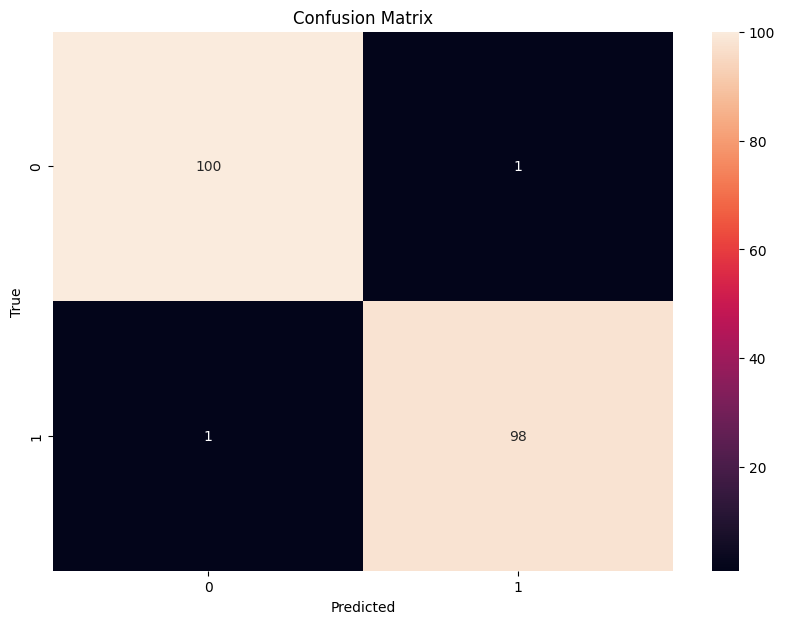

In [3]:
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = tokenized["test"]["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用seaborn绘制混淆矩阵的热力图
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 加载测试数据
test_data = pd.read_parquet("./datasets/FinQuestions_v2/test.parquet")

# 预测
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = test_data["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 找出预测错误的案例
wrong_predictions = test_data[predictions != true_labels]

# 打印预测错误的案例
for index, row in wrong_predictions.iterrows():
    print(f"True Label: {row['label']}, Predicted Label: {predictions[index]}, Text: {row['text']}")

  0%|          | 0/8 [00:00<?, ?it/s]

Confusion Matrix:
[[100   1]
 [  1  98]]
True Label: 1, Predicted Label: 0, Text: 生态环境建设行业的上游是什么行业？
True Label: 0, Predicted Label: 1, Text: e租宝的投资人能拿回多少投资?


In [5]:
text = "2024年3月18日基金走势如何？"

# classifier = pipeline("sentiment-analysis", model=output_dir+"/checkpoint-75")
# classifier(text)